In [31]:
import galsim
import matplotlib.pyplot as plt
import numpy as np
from calc_ellipticity import SimpleImageModel
from calc_moments import calc_ellip
from calc_ellipticity import addPoissonNoiseSNR

Test the galsim convolve code

In [2]:
psf = galsim.Gaussian(fwhm=0.7, flux=1)
source = galsim.DeltaFunction(flux=1e5)
convolve = galsim.Convolve([psf, source])
pix_size = 0.2

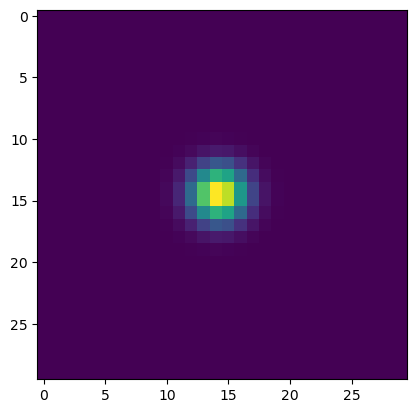

In [3]:
image = convolve.drawImage(nx=30, ny=30, scale=pix_size, offset=(0, 0))
image = convolve.drawImage(image, scale=pix_size, offset=(-0.5, 0), add_to_image=True)
plt.imshow(image.array)

In [ ]:
def addPoissonNoiseSNR(image, snr):
    # add poisson noise to the result
    refined = np.maximum(image.array, 0)
    w = refined
    snr_old = (w*refined).sum() / np.sqrt((w*w*refined).sum())
    ratio = snr / snr_old

    image *= (ratio*ratio)
    image.addNoise(galsim.PoissonNoise())

    refined = np.maximum(image.array, 0)
    w = refined
    return (w*refined).sum() / np.sqrt((w*w*refined).sum())

In [9]:
addPoissonNoiseSNR(image, 100)

100.27436

In [4]:
flux = 1e5
sky_flux = 1e3

In [41]:
snr = 100

refined = np.maximum(image.array, 0)
w = refined
snr_old = (w*refined).sum() / np.sqrt((w*w*refined).sum())

ratio = snr / snr_old

sky_level = sky_flux*ratio*ratio
image *= (ratio*ratio)
signal = image.array.copy()
image.addNoise(galsim.PoissonNoise(sky_level=sky_level))

In [42]:
refined = np.maximum(signal, 0)
w = refined
(w*refined).sum() / np.sqrt((w*w*(refined + sky_level)).sum())

90.668915

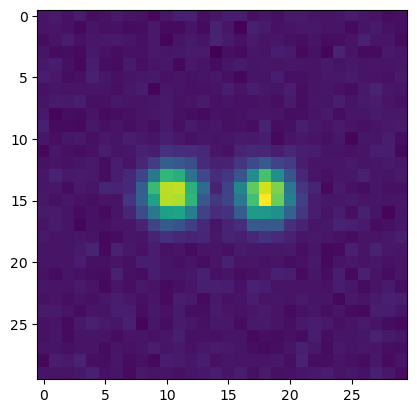

In [6]:
plt.imshow(image.array)

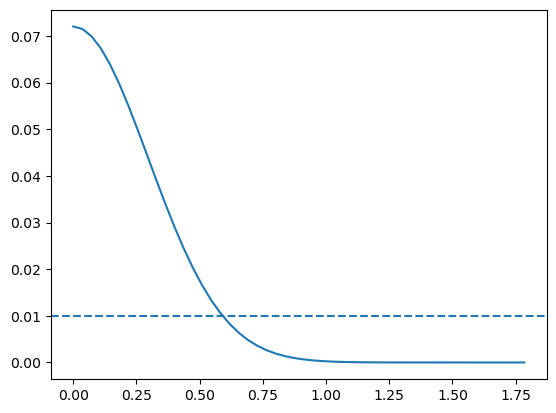

In [15]:
sigma = psf.sigma
x = np.linspace(0, 6*sigma, 50)
y = 1/(2*np.pi*sigma*sigma) * np.exp(-x*x/(2*sigma*sigma)) * pix_size * pix_size
plt.plot(x, y)
plt.axhline(y=0.01, linestyle='--')

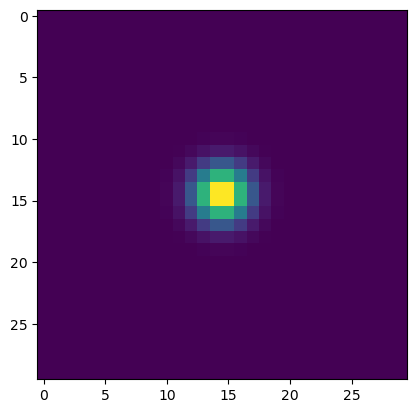

In [9]:
im = psf.drawImage(nx=30, ny=30, scale=0.2)
plt.imshow(im.array)

In [10]:
im.array.max()

0.06223258

Test the two image system

In [2]:
x_l, y_l = (0.1, 0.2)
x_ps, y_ps = (0.5, 0.7)
theta_E = 0.4

beta = np.sqrt((x_l-x_ps)**2+(y_l-y_ps)**2)
theta_p = (beta + np.sqrt(beta*beta+4*theta_E*theta_E))/2
theta_n = (beta - np.sqrt(beta*beta+4*theta_E*theta_E))/2
x = (theta_p/theta_E)**4
A_p = x/(x-1)
x = (theta_n/theta_E)**4
A_n = -x/(x-1)
assert A_p >= 0 and A_n >= 0

x_p = theta_p/beta*(x_ps - x_l) + x_l
y_p = theta_p/beta*(y_ps - y_l) + y_l
x_n = theta_n/beta*(x_ps - x_l) + x_l
y_n = theta_n/beta*(y_ps - y_l) + y_l

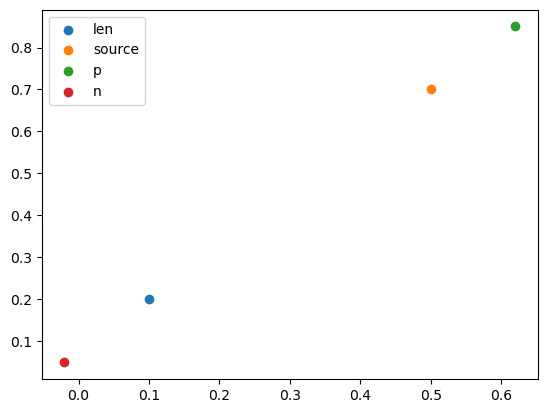

In [3]:
plt.scatter((x_l,), (y_l,), label='len')
plt.scatter((x_ps,), (y_ps,), label='source')
plt.scatter((x_p,), (y_p,), label='p')
plt.scatter((x_n,), (y_n, ), label='n')
plt.legend()
plt.show()

In [3]:
import calc_ellipticity
import importlib
importlib.reload(calc_ellipticity)

<module 'calc_ellipticity' from '/uufs/astro.utah.edu/common/home/u6060319/StaticMicrolensing/calc_ellipticity.py'>

## Add noise and calculate the result

In [65]:
from lenstronomy.Cosmo.micro_lensing import einstein_radius
M0 = 500
dl = 4000
ds = 8000
theta_E = einstein_radius(M0, dl, ds)

In [66]:
# lambda = 1.5 micro meter
deltaPix = 0.031
fwhm=0.05
figsize = (fwhm + theta_E)*10
num_pix = int(figsize/deltaPix)
psf = galsim.Gaussian(fwhm=fwhm, flux=1)

In [67]:
mymodel = SimpleImageModel(deltaPix, num_pix*2, num_pix*2, (0, 0), psf)

In [68]:
m = 500
u = 0.1
theta_E = einstein_radius(m, dl, ds)

In [69]:
flux = 100                  # relative value, will be rescaled for SNR
sky_level = 10
snr = 50

image and image with poisson noise

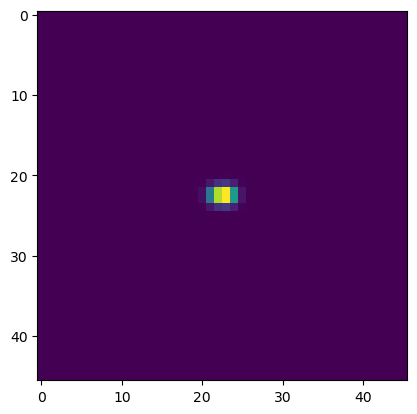

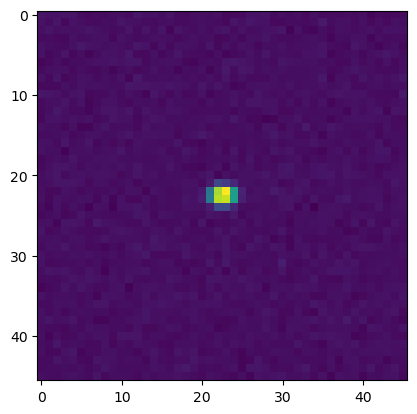

In [70]:
image = mymodel.mock_image(theta_E, 0, 0, theta_E*u, 0, flux)
image_old = image.copy()
plt.imshow(image.array)
plt.show()
ratio = addPoissonNoiseSNR(image, snr, sky_level)
plt.imshow(image.array)
plt.show()

In [71]:
from IPython.display import Math

In [75]:
mom_old = image_old.FindAdaptiveMom()
e_real = mom_old.observed_shape.e
mom = galsim.hsm.FindAdaptiveMom(image)
e_obs = mom.observed_shape.e
sig = mom.moments_sigma
Ne = ratio*flux
sky = ratio*sky_level
R2 = 1
sigma_sky = sig/(R2*Ne)*np.sqrt(4*np.pi*sky)
sigma_star = 1/R2 * np.sqrt(64/(27*Ne))
# Math(f'{sigma_sky=:5f}, {sigma_star=:5f}')
sigma = np.sqrt(sigma_sky**2 + sigma_star**2)

Math('$\\sigma_{{sky}} = {:.5f}, \\sigma_{{star}} = {:.5f}\\\\e_{{real}} = {:.5f}\\\\e_{{obs}} = {:.5f} \\pm {:.5f}$'.format(sigma_sky, sigma_star, e_real, e_obs, sigma))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

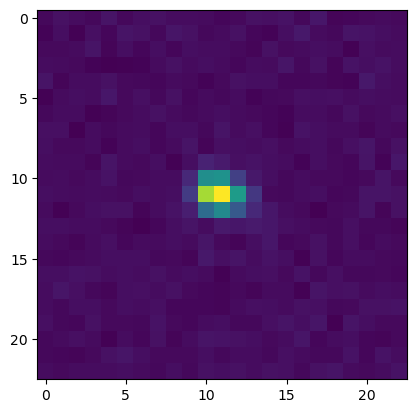

In [83]:
from calc_ellipticity import ellipticity_image_mock
res = ellipticity_image_mock(deltaPix, fwhm, 0, 0, theta_E*0.5, theta_E*0.1, theta_E, 100, True, 50, 5)
plt.imshow(res['image'].array)
Math(r'$e = {:.5f} \pm {:.5f}$'.format(res['e'], res['e_err']))

In [32]:
from lenstronomy.Cosmo.micro_lensing import einstein_radius

In [33]:
d_s = 8000
d_l = 4000              # pc
M0 = 500               # M_sol
theta_E = einstein_radius(M0, d_l, d_s)     # arcsec
deltaPix = 0.031
fwhm = 0.05
figsize = (fwhm+theta_E)*10
num_pix = int(figsize/deltaPix)
psf = galsim.Gaussian(fwhm=fwhm, flux=1)
mymodel = SimpleImageModel(deltaPix, num_pix, num_pix, (0, 0), psf)

In [40]:
image = mymodel.mock_image(theta_E, 0, 0.2*theta_E, 0, 0, 1000)

In [56]:
import importlib
import calc_moments
importlib.reload(calc_moments)

<module 'calc_moments' from '/uufs/astro.utah.edu/common/home/u6060319/StaticMicrolensing/calc_moments.py'>

In [27]:
from calc_moments import calc_ellip

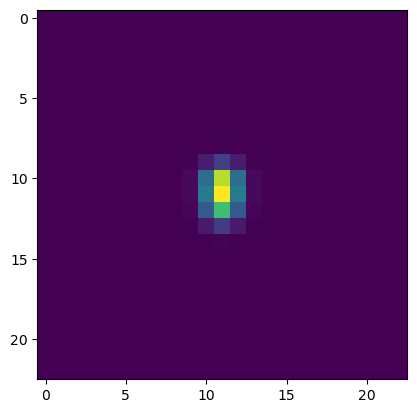

In [41]:
plt.imshow(image.array)

## figures add noise

In [98]:
# lets vary mass
add_noise = True
SNR = 100
image_2d = []
us = np.linspace(0.1, 0.5, 3)
ms = [100, 200, 500, 1000]
for u in us:
    images = []
    for m in ms:
        theta_E = einstein_radius(m, dl, ds)
        image = mymodel.mock_image(theta_E, 0, 0, theta_E*u, 0, 100)
        if add_noise:
            addPoissonNoiseSNR(image, SNR)
        images.append(image)
    image_2d.append(images)

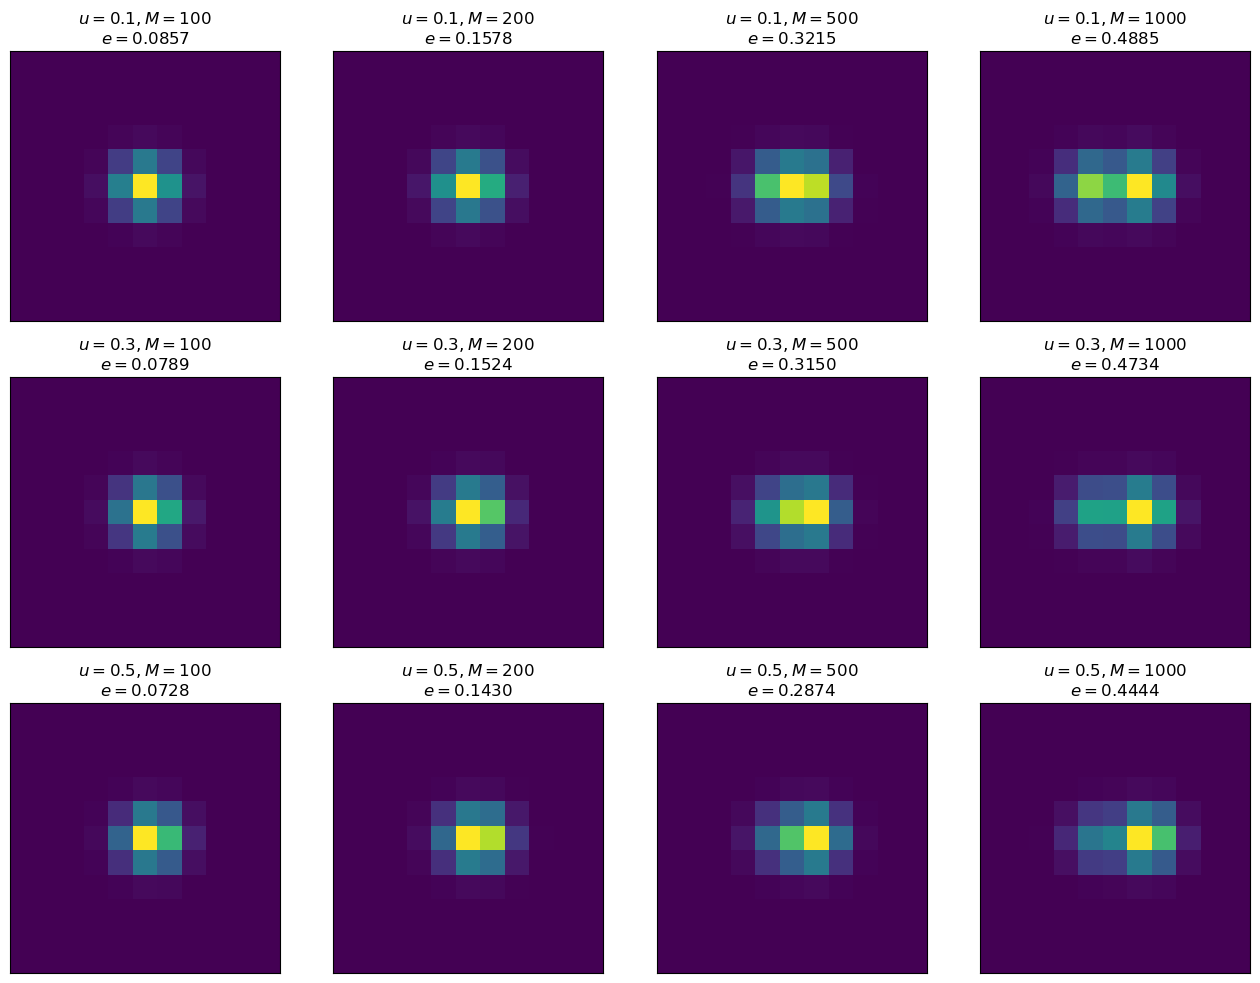

In [99]:
Nrow = 3
Ncol = 4
fig, axes = plt.subplots(Nrow, Ncol, figsize=(4*Ncol, 4*Nrow))
for i in range(Nrow):
    for j in range(Ncol):
        ax = axes[i,j]
        ax.imshow(image_2d[i][j].array)
        ax.set_title('$u = {:.1f}, M = {}$\n$e = {:.4f}$'.format(us[i], ms[j], calc_ellip(image_2d[i][j].array)[-1]))
        ax.set_xticks([])
        ax.set_yticks([])

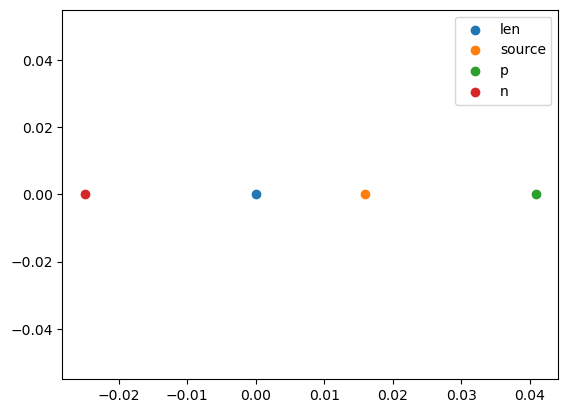

In [28]:
plt.scatter((mymodel.x_l,), (mymodel.y_l,), label='len')
plt.scatter((mymodel.x_ps,), (mymodel.y_ps,), label='source')
plt.scatter((mymodel.x_p,), (mymodel.y_p,), label='p')
plt.scatter((mymodel.x_n,), (mymodel.y_n, ), label='n')
plt.legend()
plt.show()

In [32]:
p = galsim.DeltaFunction(flux=mymodel.A_p)
n = galsim.DeltaFunction(flux=mymodel.A_n)
con_p = galsim.Convolve([psf, p])
con_n = galsim.Convolve([psf, n])

In [31]:
mymodel.A_p

1.591410312663499